In [21]:
import numpy as np
from sklearn import datasets
import matplotlib.pyplot as plt
import math
import random

# Implementare una SOM
---
Tensorflow, di base è un esecutore di grafi computazionali. I nodi sono operazioni e i dati fluiscono sugli archi. Ed è per questo che le sue performance sono molto migliori di scikit-learn. Poiché durante l’esecuzione può analizzare il grafo e stabilire le ottimizzazioni da fare (parallelizzazione di operazioni indipendenti, etc.)

In realtà nelle ultime versioni, pytorch e tensorflow, adottano lo stesso modello di valutazione (eager).

In [9]:
class SOMParameters:
    def __init__(self, eta = 0.1, radius = 4.0, tau1, tau2):
        self.eta = eta
        self.radius = radius
        self.tau1 = tau1
        self.tau2 = tau2

In [39]:
class SOM:
    def __init__(self, nrows, ncols, input_len, lr0 = 0.1, radius0 = 4.0):
        """
            Initialize your class
        """
        self.nrows = nrows
        self.ncols = ncols
        self.input_len = input_len
        self.lr0 = lr0
        self.radius0 = radius0
        self.weights = np.random.rand(nrows, ncols, input_len)

    def unit_distances(self, ex):
        """
            Returns a nrow x ncols matrix containing in cell (i,j) the euclidean distances between ex and the weight of the unit in position (i,j).
            I loop in python sono molto lenti. Ma le librerie, ridefiniscono gli operatori per supportare dati a più dimensioni.
            Quindi possiamo fare w - ex e abbiamo fatto il primo step, possiamo adesso fare la norma di ordine 2

            Occhio, la norma la vogliamo applicare all'ultimo asse della matrice.
        """
        return np.linalg.norm(self.weights - ex, ord=2, axis=len(self.weights.shape) - 1)


    def bmu(self, ex):
        """
            Given an example returns the coordinates of the unit in the map with the largest activation.
            Dato un esempio ex, dobbiamo calcolare il peso con l'attivazione più alta. Che sappiamo essere calcolata con la distanza euclidea.

            Per cominciare dobbiamo trovare la coppia minima, possiamo farlo con np.argmin, purtroppo però, questa funzione, linearizza la matrice e ci
            ritorna il minimo indice del vettore. Per capire quali siano le sue coordinate nella matrice originale, dobbiamo usare unravel_index
        """
        distances = self.unit_distances(ex)
        return np.array(np.unravel_index(np.argmin(distances), distances.shape))
        

    def lr(self, t):
        """
            Returns the learning rate for training step number 't'
        """
        return self.lr0 * np.exp(-t/self.T)

    def neighborhood_radius(self, t):
        """
            Returns the neighborhood radius at time 't'. It corresponds to sigma(n) in the theory.
        """
        return self.radius0 * np.exp(-t/self.T)

    def topological_neighborhood(self, unit1, unit2, t):
        """
            Returns the neighborhood weight for the given two units (evaluated at time t). It corresponds to function h_{j,i} in the theory.
        """
        d12 = np.linalg.norm(unit1 - unit2)
        return np.exp(-d12 ** 2 / (2*self.neighborhood_radius(t)) ** 2)

    def _train(self, ex, t):
        """
            Effettua un singolo passo del training (t)
        """
        for i in range(self.nrows):
            for j in range(self.ncols):
                self.weights[i,j] = self.weights[i,j] + self.lr(t) * self.topological_neighborhood(ex, self.weights[i,j], t)

    def extract_example_from(self, data):
        return data[math.floor(random.randint(0, self.nrows - 1)), math.floor(random.randint(0, self.ncols - 1))]

    def fit(self, data, T):
        """
            Performs 'T' training steps (you might want to store T inside a variable in the object so that it can be used to evaluate the formulae
            for the neighbor radius and for h)
        """
        self.T = T
        for t in range(T):
            ex = self.extract_example_from(data)
            self._train(ex, t)



# Experiments on the `Digits` dataset

Load the dataset

In [40]:
digits = datasets.load_digits()

`digits.data` now contains the examples in the dataset while `digits.target` contains the classess associated to the examples.

SOMs usually perform best when the data is normalized. Normalize the data (choose the technique you prefer) and put the results in X and y variables.

In [41]:
X = digits.data
y = digits.target

Instantiate the som with an n x n matrix setting an appropriate learning rate and radius. Experiment with different n, lr and radiuses to find something that gives you good results.

In [59]:
som = SOM(30,30,64,lr0=.5, radius0=4)

Train the SOM. You may want to perform at least 1000 iterations, but feel free to experiemnt with other values.

In [60]:
som.fit(X, 1000)

Use the following script to plot your results, if everything is ok, you should see the digits to be nicely organized into neat clusters in the map.

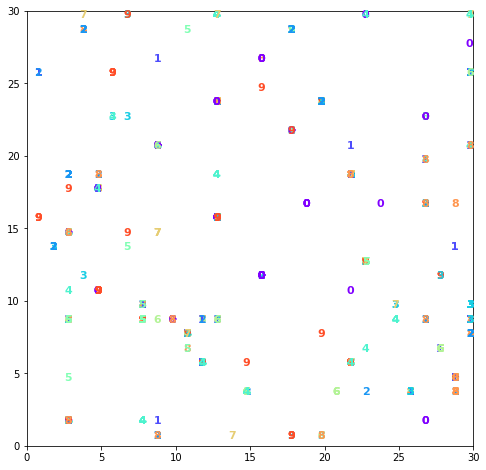

In [61]:
plt.figure(figsize=(8,8))

for x, t in zip(X,y):
    bmu = som.bmu(x)
    plt.text(bmu[0]+.5,  bmu[1]+.5,  str(t),
              color=plt.cm.rainbow(t / 10.), fontdict={'weight': 'bold',  'size': 11})

plt.axis([0, som.weights.shape[0], 0,  som.weights.shape[1]])
plt.show()


In [47]:
datax = som.weights
np.save("SOM_weights.npy", datax, False, False)